In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/kaggle/input/twitter-data/twitter_parsed_dataset.csv")

In [4]:
import pandas as pd
from gensim.utils import simple_preprocess
import nltk
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import HTML,display
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns
from collections import Counter
import itertools


from keras.layers import Input, Embedding, Dense, Bidirectional, Dropout, GRU
from keras.models import Sequential   # the model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [15]:
train = df[['Text','oh_label']]
combo = df[['Text','oh_label']]
train.columns = ['question_text','target']
combo.columns = ['question_text','target']

In [16]:
#let's see how data is looklike
random_index=random.randint(0,train.shape[0]-3)
for row in train[['question_text','target']][random_index:random_index+3].itertuples():
    _,text,label=row
    class_name=0
    if label==1:
        class_name="1"
    display(HTML(f"question_text: {text}"))
    display(HTML(f"target: {class_name}"))
#data contain so much garbage needs to be cleaned

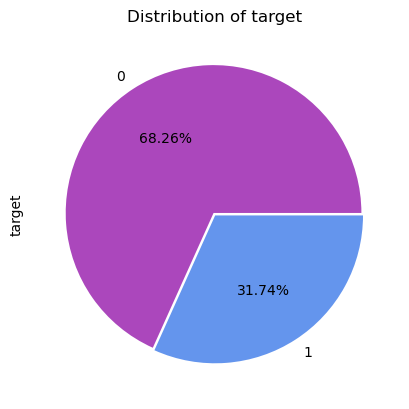

In [17]:

colors=['#AB47BC','#6495ED']
plt.pie(train['target'].value_counts(),labels=['0','1'],autopct='%.2f%%',explode=[0.01,0.01],colors=colors);
plt.title('Distribution of target')
plt.ylabel('target');

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

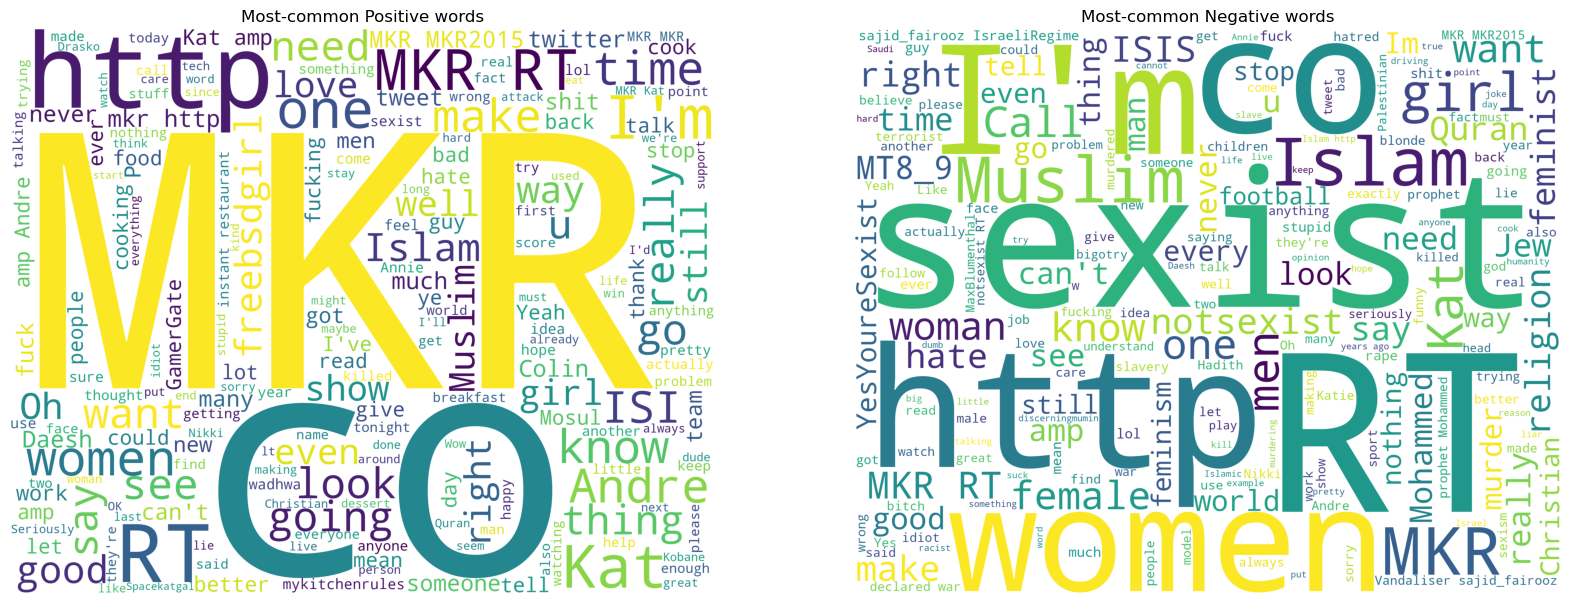

In [19]:
positivedata = train[train['target']== 0]
positivedata =positivedata['question_text']
negdata = train[train['target']== 1]
negdata= negdata['question_text']

def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word not in ['would','get','like','people','think','take'])])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(positivedata,'white','Most-common Positive words')

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'white','Most-common Negative words')
plt.show()

In [34]:
train['question_text'] = train['question_text'].astype('str')
combo['question_text'] = combo['question_text'].astype('str')

/tmp/ipykernel_28/912477167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['question_text'] = train['question_text'].astype('str')
/tmp/ipykernel_28/912477167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['question_text'] = combo['question_text'].astype('str')


In [35]:
train['text_word_count']=train['question_text'].apply(lambda x:len(x.split()))

numerical_feature_cols=['text_word_count']

/tmp/ipykernel_28/3952667569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text_word_count']=train['question_text'].apply(lambda x:len(x.split()))


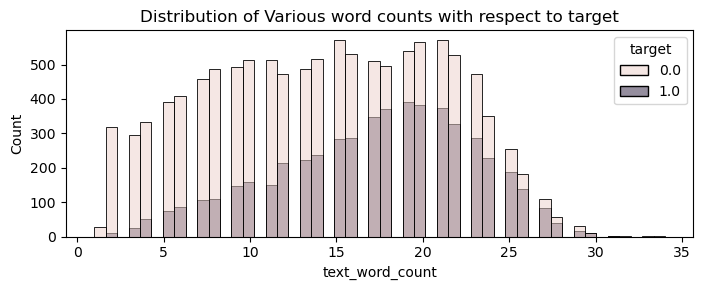

In [36]:


plt.figure(figsize=(20,3))
for i,col in enumerate(numerical_feature_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=train,x=col,hue='target',bins=50)
    plt.title(f"Distribution of Various word counts with respect to target")
plt.tight_layout()
plt.show()
     


In [37]:
combo['question_text'] = combo['question_text'].apply(lambda x:simple_preprocess(x))

/tmp/ipykernel_28/2699072842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['question_text'] = combo['question_text'].apply(lambda x:simple_preprocess(x))


In [41]:
combo['question_text'] = combo['question_text'].apply(lambda tokens: ' '.join(tokens))

/tmp/ipykernel_28/3616320183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['question_text'] = combo['question_text'].apply(lambda tokens: ' '.join(tokens))


In [42]:
def custom_preprocess(s):
    # Initialize WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Define your own preprocessing steps
    filters = [lambda x: x.lower(),  # Convert to lowercase
               strip_tags,  # Remove HTML tags
               strip_punctuation,  # Remove punctuation
               strip_multiple_whitespaces,  # Remove multiple whitespaces
               strip_numeric,  # Remove numbers
               remove_stopwords,  # Remove stopwords
               strip_short,  # Remove short words
               lambda x: lemmatizer.lemmatize(x)]  # Lemmatization step

    return preprocess_string(s, filters)

In [45]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [46]:
combo['question_text'] = combo['question_text'].apply(lambda x:custom_preprocess(x))

/tmp/ipykernel_28/3295490068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['question_text'] = combo['question_text'].apply(lambda x:custom_preprocess(x))


In [49]:
combo['question_text'] = combo['question_text'].apply(lambda tokens: ' '.join(tokens))

/tmp/ipykernel_28/3616320183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['question_text'] = combo['question_text'].apply(lambda tokens: ' '.join(tokens))


In [50]:

def get_text_length(text):
    tokens = simple_preprocess(text)
    return len(tokens)
     

In [51]:
combo['text_length'] = combo['question_text'].apply(get_text_length)

/tmp/ipykernel_28/1840653219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['text_length'] = combo['question_text'].apply(get_text_length)


In [52]:

def get_text_length(text):
    tokens = simple_preprocess(text)
    return len(tokens)

In [53]:
combo['text_length'] = combo['question_text'].apply(get_text_length)

/tmp/ipykernel_28/1840653219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['text_length'] = combo['question_text'].apply(get_text_length)


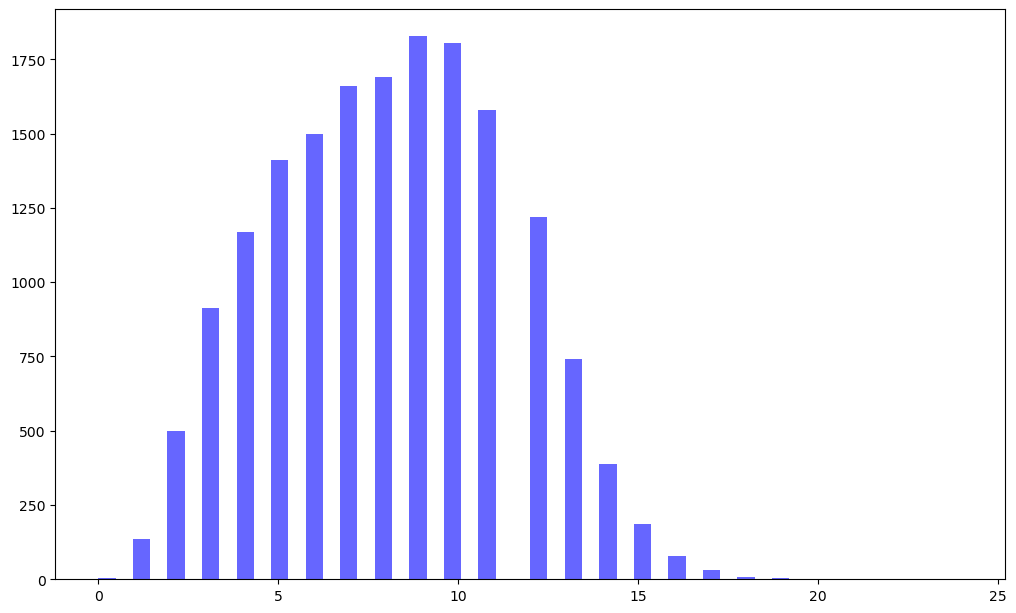

In [54]:


fig = plt.figure(figsize=(10,6))
# Add axes to the figure. Create the first main window
ax1 = fig.add_axes([0, 0, 0.95, 0.95])
ax1.hist(np.array(combo.text_length), bins=50, label='length', alpha=0.6, color='blue');
     


In [55]:
combo['text_length'].quantile(0.995)

16.0

In [56]:
combo['question_text'] = combo['question_text'].apply(lambda x:simple_preprocess(x, max_len=17))

/tmp/ipykernel_28/2222545204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['question_text'] = combo['question_text'].apply(lambda x:simple_preprocess(x, max_len=17))


In [57]:
combo['question_text'] = combo['question_text'].apply(lambda tokens: ' '.join(tokens))

/tmp/ipykernel_28/3616320183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['question_text'] = combo['question_text'].apply(lambda tokens: ' '.join(tokens))


In [58]:


all_tokens = list(itertools.chain.from_iterable([i.split() for i in combo.question_text]))
token_counts = Counter(all_tokens)
sorted_token_counts = dict(sorted(token_counts.items(), key=lambda item: item[1], reverse=True))
len(sorted_token_counts)
count = 0
for key, value in sorted_token_counts.items():
    if value > 11:
        count+=1
print(count)
sorted_token_counts.get('approach', 0)
     


1911


5

In [59]:

def vocab_limiter(x):
    x = x.split()
    y = []
    for i in x:
        if sorted_token_counts.get(i, 0) > 11:
            y.append(i)
    return ' '.join(y)

In [60]:
combo['question_text'] = combo['question_text'].apply(vocab_limiter)

/tmp/ipykernel_28/3656874032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo['question_text'] = combo['question_text'].apply(vocab_limiter)


In [61]:
import tensorflow as tf

In [63]:


MAX_SENT_LEN = 17   # Number of words to consider from each review
MAX_VOCAB_SIZE = 2000 # Max vocabulary size
BATCH_SIZE = 128
N_EPOCHS = 5
     


In [68]:
combo = combo.fillna(0)

In [69]:


tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(combo['question_text'])
print("Number of words in vocabulary:", len(tokenizer.word_index))
X = tokenizer.texts_to_sequences(combo['question_text'])
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y = combo['target']
testX = X[15000:]
testy = y[15000:]
X = X[:15000]
y = y[:15000]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size = 0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
embeddings_index = {}

Number of words in vocabulary: 1911


In [70]:
!wget https://nlp.stanford.edu/data/glove.42B.300d.zip

--2023-08-20 11:16:46--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2023-08-20 11:16:46--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

glove.42B.300d.zip  100%[===================>]   1.75G  5.04MB/s    in 5m 53s  

2023-08-20 11:22:40 (5.07 MB/s) - ‘glove.42B.300d.zip’ saved [1877800501/1877800501]



In [71]:
!unzip glove*.zip

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [73]:
f = open('/kaggle/working/glove.42B.300d.txt')

In [74]:
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
     

1917494it [02:47, 11481.96it/s]


Found 1917494 word vectors.


In [75]:

# Adding 1 because of reversed 0 index
words_not_found = []
vocab_size = len(tokenizer.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1917494 word vectors.


In [76]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
len(tokenizer.word_index.items())

1911

In [77]:


for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
     


In [78]:
len(words_not_found)

216

In [79]:
print(len(tokenizer.word_index))

1911


In [80]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [81]:
weights_assigned={0:1,1:10}

In [82]:

# Build a sequential model by stacking neural net units
model = Sequential()
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights = [embedding_matrix],
                            trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.50, name='first_gru_layer')))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(64, name='second_gru_layer')))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid', name='output_layer'))
     

In [83]:

print('Summary of the built model...')
model.summary()

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         573600    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        330240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              123648    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)            

In [84]:


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC'])
     


In [85]:
     

model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=2,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping],
          class_weight=weights_assigned)
     


Epoch 1/2
106/106 [==============================] - 14s 25ms/step - loss: 1.8997 - auc: 0.6541 - val_loss: 0.8495 - val_auc: 0.8340
Epoch 2/2
106/106 [==============================] - 1s 12ms/step - loss: 1.6739 - auc: 0.7516 - val_loss: 0.8581 - val_auc: 0.8515


In [86]:

print('Testing...')
model.evaluate(X_test, y_test)

Testing...
47/47 [==============================] - 0s 5ms/step - loss: 0.8581 - auc: 0.8515


[0.8581045866012573, 0.8514511585235596]

In [87]:
predz = model.predict(X_test)

47/47 [==============================] - 1s 4ms/step


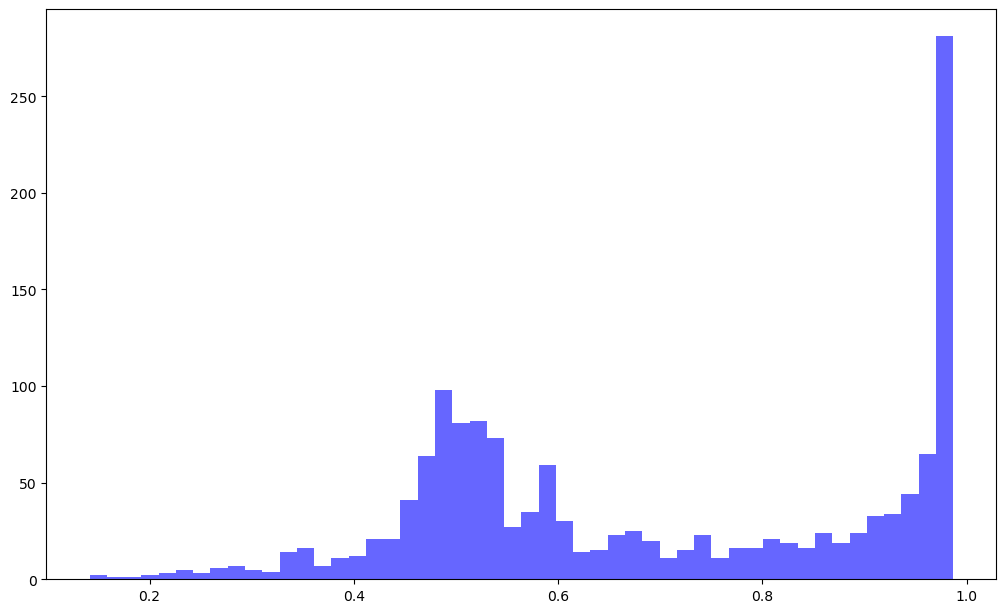

In [88]:


fig = plt.figure(figsize=(10,6))
# Add axes to the figure. Create the first main window
ax1 = fig.add_axes([0, 0, 0.95, 0.95])
ax1.hist(np.array(predz), bins=50, label='length', alpha=0.6, color='blue');
     


In [89]:
y_predz1 = [1 if i >= 0.92 else 0 for i in predz]

In [90]:
print(classification_report(y_test.to_numpy(), y_predz1, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1022
           1       0.75      0.67      0.71       478

    accuracy                           0.82      1500
   macro avg       0.80      0.78      0.79      1500
weighted avg       0.82      0.82      0.82      1500

